# Set up the environment

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pyextremes import __version__, EVA, get_extremes
from pyextremes.models import Emcee
from pyextremes.plotting import (
    plot_extremes,
    pyextremes_rc,
    plot_trace,
    plot_corner,
)
print("pyextremes", __version__)

pyextremes 1.1.0


# Load the data

In [2]:
data = pd.read_csv('../../data/battery_wl.csv', index_col=0, parse_dates=True, squeeze=True)
data = (
    data
    .sort_index(ascending=True)
    .astype(float)
    .dropna()
)

data = data.loc[pd.to_datetime('1925'):]
data = data - (data.index.array - pd.to_datetime('1992')) / pd.to_timedelta('1Y') * 2.87e-3

data.head()

Date-Time (GMT)
1926-11-20 05:00:00   -0.411120
1926-11-20 06:00:00   -0.777120
1926-11-20 07:00:00   -1.051120
1926-11-20 08:00:00   -1.051121
1926-11-20 09:00:00   -0.808121
Name: Water Elevation [m NAVD88], dtype: float64

# Plot extreme values

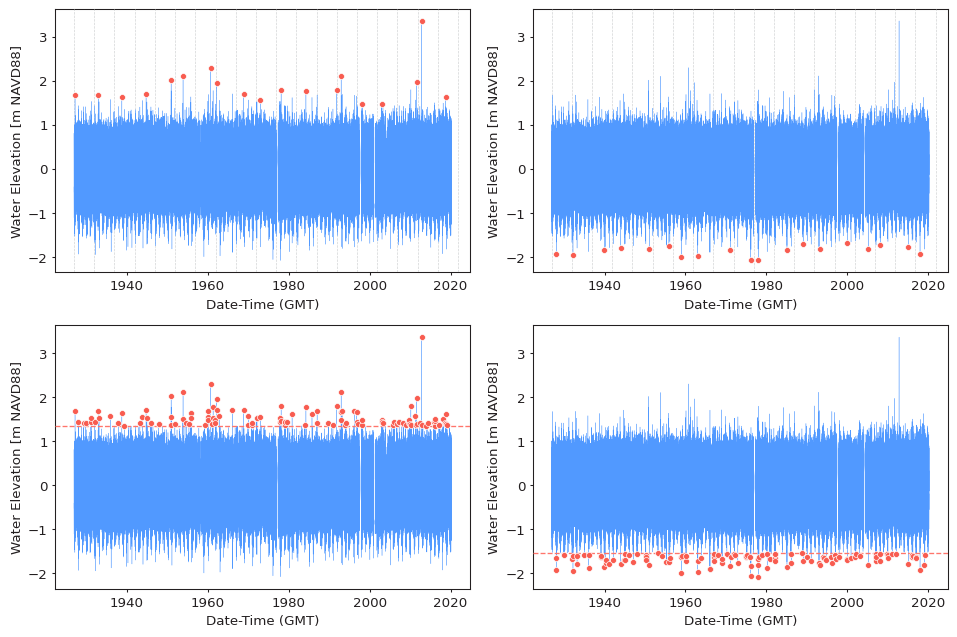

In [3]:
with plt.rc_context(rc=pyextremes_rc):
    fig, axes = plt.subplots(
        nrows=2,
        ncols=2,
        figsize=(12, 8),
        dpi=96,
        sharex=False,
        sharey=False,
        gridspec_kw={"hspace": 0.2, "wspace": 0.15},
    )
    
    for i, method in enumerate(["BM", "POT"]):
        for j, extremes_type in enumerate(["high", "low"]):
            if method == "BM":
                extremes_kwargs = {"block_size": "5Y", "errors": "ignore"}
                plot_kwargs = {"block_size": extremes_kwargs["block_size"]}
            else:
                extremes_kwargs = {"r": "24H"}
                if extremes_type == "high":
                    extremes_kwargs["threshold"] = 1.35
                else:
                    extremes_kwargs["threshold"] = -1.55
                plot_kwargs = {"threshold": extremes_kwargs["threshold"]}
            plot_kwargs["ax"] = axes[i, j]
            
            extremes = get_extremes(
                ts=data,
                method=method,
                extremes_type=extremes_type,
                **extremes_kwargs,
            )
            
            plot_extremes(
                ts=data,
                extremes=extremes,
                extremes_method=method,
                extremes_type=extremes_type,
                **plot_kwargs,
            )
    
    fig.savefig("./readme figures/extremes.png", bbox_inches="tight")

# Plot trace and corner plots

In [4]:
extremes = get_extremes(
    ts=data,
    method="BM",
    extremes_type="high",
    block_size="1Y",
    errors="raise",
)

model = Emcee(
    extremes=extremes,
    distribution="genextreme",
    distribution_kwargs=None,
    n_walkers=100,
    n_samples=500,
    progress=False,
)

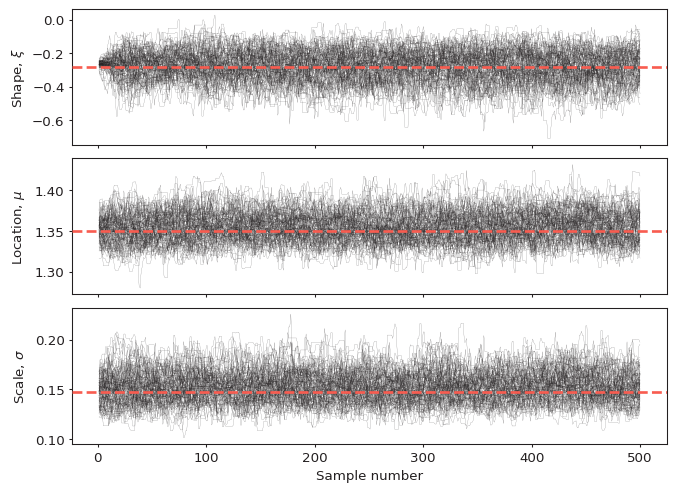

In [5]:
fig, axes = plot_trace(
    trace=model.trace,
    trace_map=model.trace_map,
    burn_in=0,
    labels=[r"Shape, $\xi$", r"Location, $\mu$", r"Scale, $\sigma$"],
)
fig.savefig("./readme figures/trace.png", bbox_inches="tight")

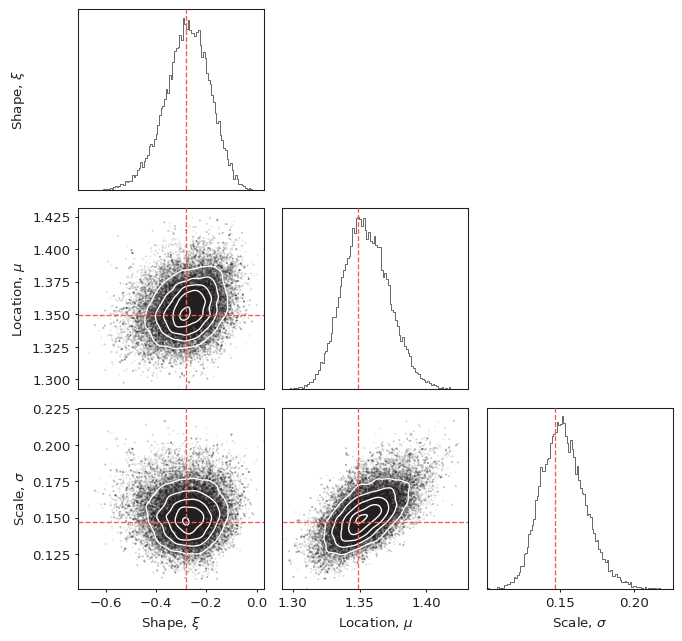

In [6]:
fig, axes = plot_corner(
    trace=model.trace,
    trace_map=model.trace_map,
    burn_in=50,
    labels=[r"Shape, $\xi$", r"Location, $\mu$", r"Scale, $\sigma$"],
    levels=5,
)
fig.savefig("./readme figures/corner.png", bbox_inches="tight")

# Plot diagnostic plot

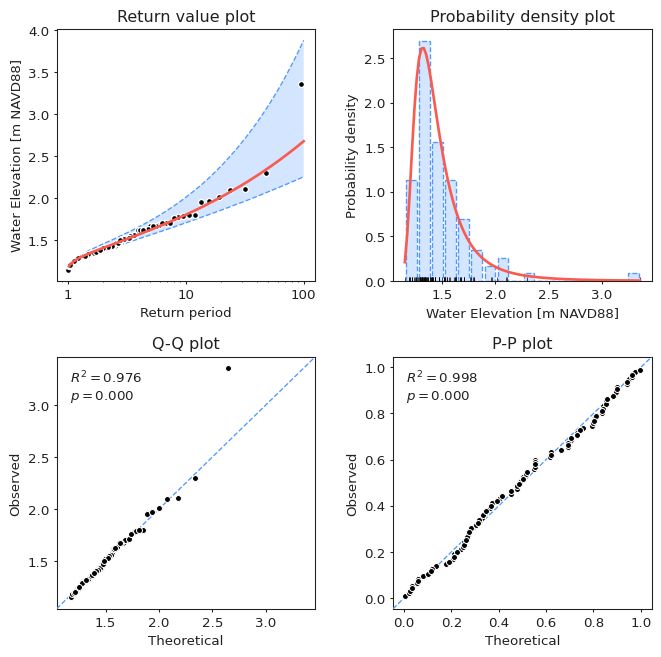

In [7]:
model = EVA(data=data)
model.get_extremes(
    method="BM",
    extremes_type="high",
    block_size="1Y",
    errors="raise"
)
model.fit_model(
    model="Emcee",
    distribution="genextreme",
    distribution_kwargs=None,
    n_walkers=100,
    n_samples=500,
    progress=False,
)
fig, axes = model.plot_diagnostic(
    return_period=np.logspace(start=0.01, stop=2, num=100),
    alpha=0.95
)
fig.savefig("./readme figures/diagnostic.png", bbox_inches="tight")